In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from conditional_VAE import conditional_VAE, loss_function

In [15]:
path = "cmnist/fgbg_cmnist_cpr0.5-0.5/"
mnist_train = torch.from_numpy(np.load(path + "colored_mnist_init_train.npy"))
mnist_test = torch.from_numpy(np.load(path + "colored_mnist_init_test.npy"))
mnist_train_target = torch.from_numpy(np.load(path + "colored_mnist_target_train.npy"))
mnist_test_target = torch.from_numpy(np.load(path + "colored_mnist_target_test.npy"))

batch_size = 128
train_dataset = TensorDataset(mnist_train, mnist_train_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TensorDataset(mnist_test, mnist_test_target)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
print(mnist_train.shape, mnist_test.shape)
print(mnist_train_target.shape, mnist_test_target.shape)

torch.Size([60000, 3, 28, 28]) torch.Size([10000, 3, 28, 28])
torch.Size([60000, 7]) torch.Size([10000, 7])


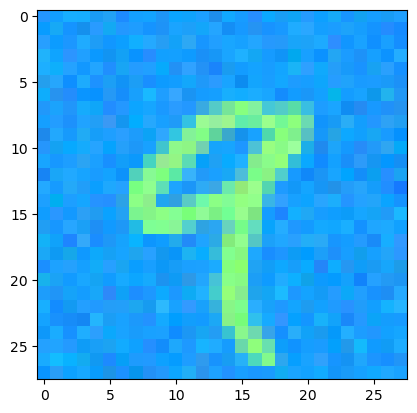

In [17]:
plt.imshow(mnist_train[4].permute(1, 2, 0))
plt.show()

In [18]:
torch.manual_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Selected device: {device}")

vae = conditional_VAE(shape=(3, 28, 28), latent_dim=128, conditional_dim=7)
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-3)

Selected device: cuda


In [19]:
num_epochs = 10

for epoch in range(num_epochs):
    vae.train()
    train_loss = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        x_hat, mean, logvar = vae(x, y)
        loss = loss_function(x, x_hat, mean, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_loader.dataset)

    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            x_hat, mean, logvar = vae(x, y)
            loss = loss_function(x, x_hat, mean, logvar)

            val_loss += loss.item()
    val_loss = val_loss / len(test_loader.dataset)

    print(
        "\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}".format(
            epoch + 1, num_epochs, train_loss, val_loss
        )
    )


 EPOCH 1/10 	 train loss 83.824 	 val loss 79.267

 EPOCH 2/10 	 train loss 42.102 	 val loss 74.636

 EPOCH 3/10 	 train loss 35.047 	 val loss 70.910

 EPOCH 4/10 	 train loss 31.095 	 val loss 72.317

 EPOCH 5/10 	 train loss 28.453 	 val loss 68.592

 EPOCH 6/10 	 train loss 26.515 	 val loss 75.328

 EPOCH 7/10 	 train loss 25.122 	 val loss 75.682

 EPOCH 8/10 	 train loss 23.956 	 val loss 74.973

 EPOCH 9/10 	 train loss 22.986 	 val loss 79.743

 EPOCH 10/10 	 train loss 22.145 	 val loss 77.223


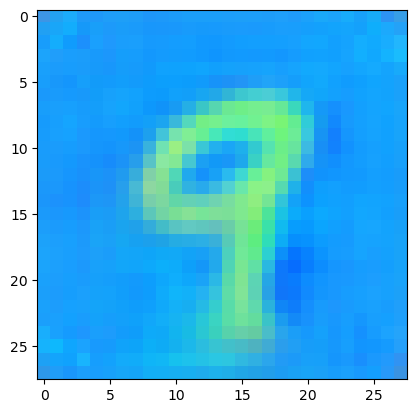

In [25]:
with torch.no_grad():
    reconstructed_image, _, _ = vae(
        mnist_train[4, :, :, :].unsqueeze(0).to(device),
        mnist_train_target[4, :].unsqueeze(0).to(device),
    )
    plt.imshow(reconstructed_image.cpu().squeeze().permute(1, 2, 0))

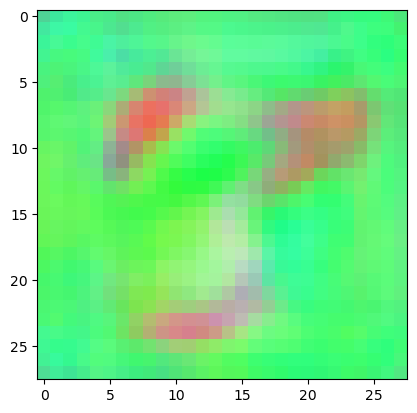

In [29]:
with torch.no_grad():
    condition = mnist_train_target[1, :]
    condition[0] = 5
    generated_image = vae.generate(condition.unsqueeze(0).to(device))
    plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0))